# Simple chatbot

In [1]:
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import StateGraph, MessagesState, START, END

def call_model(state:MessagesState):
    messages = state['messages']
    llm = ChatGroq(model="gemma2-9b-it")
    response = llm.invoke(messages)
    return {"messages": [response]}


In [2]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("chatbot",call_model)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

app = graph_builder.compile()

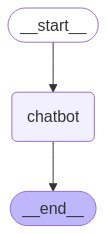

In [3]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Hello, how are you?"
        }
    ]
}   

app.invoke(input)

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='8c04ff8a-7fee-430b-9e75-45d7ac044fb8'),
  AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to help! How can I assist you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 15, 'total_tokens': 46, 'completion_time': 0.056363636, 'prompt_time': 0.001906636, 'queue_time': 0.231901203, 'total_time': 0.058270272}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d0dcaa4d-c759-4599-993a-b66683313ce3-0', usage_metadata={'input_tokens': 15, 'output_tokens': 31, 'total_tokens': 46})]}

In [5]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to assist you! How can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 15, 'total_tokens': 47, 'completion_time': 0.058181818, 'prompt_time': 0.001903976, 'queue_time': 0.233139873, 'total_time': 0.060085794}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-a9c813f6-73c2-42be-a016-15d7043b6c20-0', usage_metadata={'input_tokens': 15, 'output_tokens': 32, 'total_tokens': 47})]}




# chatbot with tools

In [1]:
from langchain_core.tools import tool
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [2]:
from langgraph.prebuilt import ToolNode
tools=[search]
tool_node=ToolNode(tools)

In [3]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langgraph.graph import StateGraph, MessagesState, START, END
def chatbot_with_tools(state:MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


In [5]:
from typing import Literal
def router_function(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [6]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", chatbot_with_tools)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})
workflow.add_edge("tools", "agent")

app = workflow.compile()

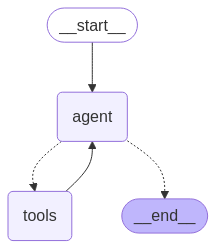

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y6h3', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.041526882, 'queue_time': 0.31178437600000003, 'total_time': 0.190617791}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fc01c609-0583-4339-9e4d-e4ab85c9757b-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_y6h3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='c61584a6-682e-4d37-b8ea-26d036c259ce', tool_call_id='call_y6h3')]}


here

# chatbot with memory

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [16]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", chatbot_with_tools)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})
workflow.add_edge("tools", "agent")

app3 = workflow.compile(checkpointer=memory)

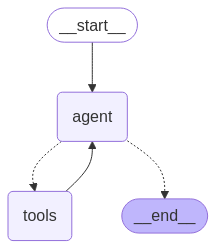

In [17]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}

In [19]:
events = app3.stream(
    {"messages": ["Hi there! My name is Rohit."]}, config, stream_mode="values"
)

In [20]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Rohit.
================================== Ai Message ==================================

Hello Rohit, it's nice to meet you!
